# Model Learning experiment

This notebook reproduces the Model Learning experiment from the STOMP paper.

As in the implementation from the paper, the TwoRooms environment has 72 states, the 72 non-terminal grid cells.

In [ ]:
""" Imports """
import numpy as np

from common.utils import load_model, save_model
from gridworld.gridworld import GridWorld
from gridworld.room_design import stomp_two_room_design
from stomp.framework import STOMP


In [2]:
%load_ext autoreload
%autoreload 1
%aimport gridworld.gridworld
%aimport stomp.framework
%aimport stomp.steps.model_learning

In [3]:
""" Experiment Parameters """

runs = 1
number_of_steps = 50000
subgoal_state_idx = 30  # this is the hallway state in the TwoRooms
subgoal_idx = 0  # we are learning only one option in this example

env = GridWorld(room_array=stomp_two_room_design)

env.num_states

load_option = True

In [4]:
""" Option value function and policy """

# If not, learn
if not load_option:
    state = env.reset()
    state_features = env.get_one_hot_state(state)
    initial_state_features = state_features

    _stomp = STOMP(
        env=env,
        subgoal_states_info={subgoal_state_idx: (7, 3)},  # hallway state position in the grid
    )

    # Local access to option learning
    option_learning = _stomp.option_learning

    initial_state_estimative, rmse_of_states = option_learning.learn_options(
        subgoal_idx, number_of_steps, return_rmse=True
    )

    # Get learned option value function and policy
    option_w = _stomp.stomp_foundation.w_subgoal[subgoal_idx]
    option_theta = _stomp.stomp_foundation.theta_subgoal[subgoal_idx]

else:
    option_w = load_model("w_reward_respecting_hallway_option.npy")
    option_theta = load_model("theta_reward_respecting_hallway_option.npy")


state = env.reset()
initial_state_features = env.get_one_hot_state(state)

# Check if the learned option value function is close to the expected value
import math
assert math.isclose(option_w @ initial_state_features, 0.831, rel_tol=0.05)

In [5]:
""" Check learned parameters """

assert option_w is not None
assert option_theta is not None


In [6]:
""" Run Experiment """

# Store statistics
many_reward_model_rmses = np.zeros((runs, number_of_steps))
many_transition_model_errors = np.zeros((runs, number_of_steps))

for i in range(runs):
    print(f"Run {i + 1}/{runs}")

    env.reset()
    _stomp = STOMP(
        env=env,
        subgoal_states_info={subgoal_state_idx: (7, 3)},  # hallway state position in the grid
    )

    # Initialize option with previously learned parameters
    _stomp.stomp_foundation.w_subgoal[subgoal_idx] = option_w
    _stomp.stomp_foundation.theta_subgoal[subgoal_idx] = option_theta

    # Local access to model learning
    model_learning = _stomp.model_learning

    # Only one option besides the primitive actions
    option_idx = _stomp.stomp_foundation.env.num_actions

    reward_model_rmses, transition_model_errors = model_learning.learn_model(
        option_idx, number_of_steps
    )

    # Store results
    many_reward_model_rmses[i] = reward_model_rmses
    many_transition_model_errors[i] = transition_model_errors


# Save models
w_rewards = _stomp.stomp_foundation.w_rewards[subgoal_idx]
W_transitions = _stomp.stomp_foundation.W_transitions[subgoal_idx]
save_model(w_rewards, "w_rewards_reward_respecting_hallway_option.npy")
save_model(W_transitions, "W_transitions_reward_respecting_hallway_option.npy")

Run 1/1


100%|██████████| 50000/50000 [02:09<00:00, 387.36it/s]


## Plot

In [7]:
import matplotlib.pyplot as plt

def plot_model_results(
        average_error_rmses,
        stddev_error_rmses,
        average_transition_error,
        stddev_transition_error,
        number_of_steps=50000
        ):
        # Create the figure and primary axis
        fig, ax1 = plt.subplots(figsize=(10, 6))

        # Primary axis (left y-axis) for error (red)
        ax1.set_xlabel('Steps of off-policy experience', fontsize=12, color='black')
        ax1.set_ylabel('Error in reward model', color='coral', fontsize=12)
        ax1.plot(range(number_of_steps), average_error_rmses, color='coral', linewidth=2)
        ax1.fill_between(
        range(number_of_steps),
        average_error_rmses - stddev_error_rmses,
        average_error_rmses + stddev_error_rmses,
        color='coral',
        alpha=0.3
        )
        ax1.tick_params(axis='y', labelcolor='coral')
        ax1.set_xlim(0, number_of_steps)
        ax1.set_ylim(0, 0.6)
        ax1.grid(False)

        # Secondary axis (right y-axis) for value function (blue)
        ax2 = ax1.twinx()
        ax2.set_ylabel('Error in transition model', color='skyblue', fontsize=12)
        ax2.plot(range(number_of_steps), average_transition_error, color='skyblue', linewidth=2)
        # ax2.fill_between(
        #     range(number_of_steps),
        #     average_error_rmses - stddev_error_rmses,
        #     average_error_rmses + stddev_error_rmses,
        #     color='skyblue',
        #     alpha=0.3
        # )
        ax2.tick_params(axis='y', labelcolor='skyblue')
        ax2.set_ylim(0, .2)
        ax2.grid(False)

        # Style the plot
        for spine in ax1.spines.values():
                spine.set_color('black')
        for spine in ax2.spines.values():
                spine.set_color('black')

        ax1.tick_params(colors='black')
        ax2.tick_params(colors='black')
        ax1.xaxis.label.set_color('black')

        plt.tight_layout()
        plt.show()


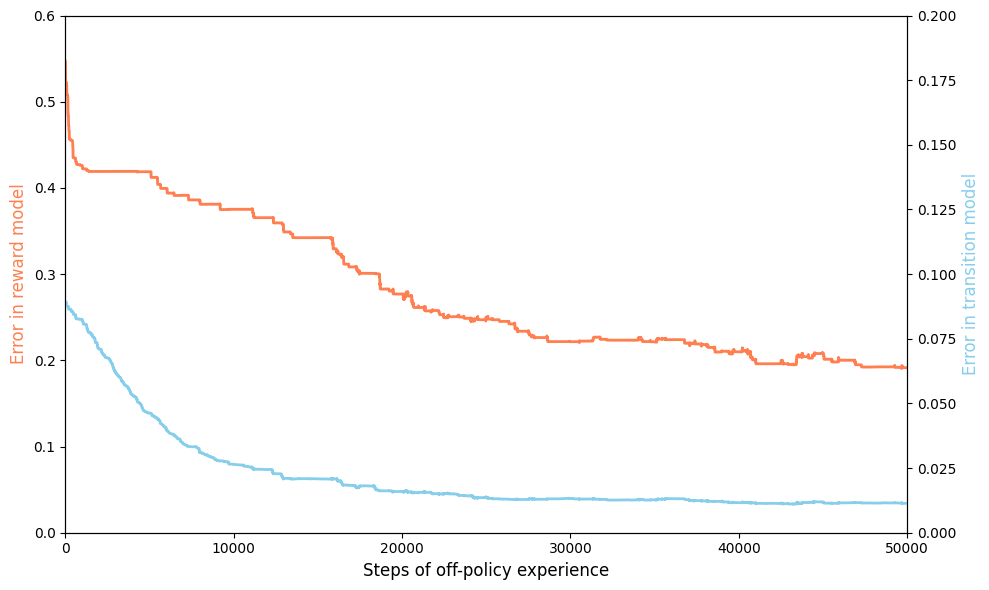

In [8]:
plot_model_results(
    average_error_rmses=np.mean(many_reward_model_rmses, axis=0),
    stddev_error_rmses=np.std(many_reward_model_rmses, axis=0),
    average_transition_error=np.mean(many_transition_model_errors, axis=0),
    stddev_transition_error=np.std(many_transition_model_errors, axis=0),
    number_of_steps=number_of_steps
)

## Learning models for primitive options

Learning models for options of the primitive actions.

### Up

In [9]:
""" Run Experiment : UP """

option_idx = 0  # Up

# Store statistics
many_reward_model_rmses_up = np.zeros((runs, number_of_steps))
many_transition_model_errors_up = np.zeros((runs, number_of_steps))

for i in range(runs):
    print(f"Run {i + 1}/{runs}")

    env.reset()
    _stomp = STOMP(
        env=env,
        subgoal_states_info={subgoal_state_idx: (7, 3)},  # hallway state position in the grid
    )

    # Local access to model learning
    model_learning = _stomp.model_learning

    reward_model_rmses, transition_model_errors = model_learning.learn_model(
        option_idx, number_of_steps
    )

    # Store results
    many_reward_model_rmses_up[i] = reward_model_rmses
    many_transition_model_errors_up[i] = transition_model_errors


# Save models
option_idx = 0  # up
w_rewards = _stomp.stomp_foundation.w_rewards[option_idx]
W_transitions = _stomp.stomp_foundation.W_transitions[option_idx]
save_model(w_rewards, "w_rewards_up_option.npy")
save_model(W_transitions, "W_transitions_up_option.npy")


Run 1/1


100%|██████████| 50000/50000 [02:04<00:00, 400.38it/s]


### Down

In [10]:
""" Run Experiment : DOWN """

option_idx = 1  # Down

# Store statistics
many_reward_model_rmses_down = np.zeros((runs, number_of_steps))
many_transition_model_errors_down = np.zeros((runs, number_of_steps))

for i in range(runs):
    print(f"Run {i + 1}/{runs}")

    env.reset()
    _stomp = STOMP(
        env=env,
        subgoal_states_info={subgoal_state_idx: (7, 3)},  # hallway state position in the grid
    )

    # Local access to model learning
    model_learning = _stomp.model_learning

    reward_model_rmses, transition_model_errors = model_learning.learn_model(
        option_idx, number_of_steps
    )

    # Store results
    many_reward_model_rmses_down[i] = reward_model_rmses
    many_transition_model_errors_down[i] = transition_model_errors


# Save models
option_idx = 1  # down
w_rewards = _stomp.stomp_foundation.w_rewards[option_idx]
W_transitions = _stomp.stomp_foundation.W_transitions[option_idx]
save_model(w_rewards, "w_rewards_down_option.npy")
save_model(W_transitions, "W_transitions_down_option.npy")


Run 1/1


100%|██████████| 50000/50000 [02:06<00:00, 394.24it/s]


### Left

In [11]:
""" Run Experiment : LEFT """

option_idx = 2  # Left

# Store statistics
many_reward_model_rmses_left = np.zeros((runs, number_of_steps))
many_transition_model_errors_left = np.zeros((runs, number_of_steps))

for i in range(runs):
    print(f"Run {i + 1}/{runs}")

    env.reset()
    _stomp = STOMP(
        env=env,
        subgoal_states_info={subgoal_state_idx: (7, 3)},  # hallway state position in the grid
    )

    # Local access to model learning
    model_learning = _stomp.model_learning

    reward_model_rmses, transition_model_errors = model_learning.learn_model(
        option_idx, number_of_steps
    )

    # Store results
    many_reward_model_rmses_left[i] = reward_model_rmses
    many_transition_model_errors_left[i] = transition_model_errors


# Save models
option_idx = 2  # left
w_rewards = _stomp.stomp_foundation.w_rewards[option_idx]
W_transitions = _stomp.stomp_foundation.W_transitions[option_idx]
save_model(w_rewards, "w_rewards_left_option.npy")
save_model(W_transitions, "W_transitions_left_option.npy")


Run 1/1


100%|██████████| 50000/50000 [02:05<00:00, 398.55it/s]


### Right

In [12]:
""" Run Experiment : RIGHT """

option_idx = 3  # Right

# Store statistics
many_reward_model_rmses_right = np.zeros((runs, number_of_steps))
many_transition_model_errors_right = np.zeros((runs, number_of_steps))

for i in range(runs):
    print(f"Run {i + 1}/{runs}")

    env.reset()
    _stomp = STOMP(
        env=env,
        subgoal_states_info={subgoal_state_idx: (7, 3)},  # hallway state position in the grid
    )

    # Local access to model learning
    model_learning = _stomp.model_learning

    reward_model_rmses, transition_model_errors = model_learning.learn_model(
        option_idx, number_of_steps
    )

    # Store results
    many_reward_model_rmses_right[i] = reward_model_rmses
    many_transition_model_errors_right[i] = transition_model_errors


# Save models
option_idx = 3  # right
w_rewards = _stomp.stomp_foundation.w_rewards[option_idx]
W_transitions = _stomp.stomp_foundation.W_transitions[option_idx]
save_model(w_rewards, "w_rewards_right_option.npy")
save_model(W_transitions, "W_transitions_right_option.npy")


Run 1/1


100%|██████████| 50000/50000 [02:05<00:00, 398.21it/s]


### Plot primitive actions

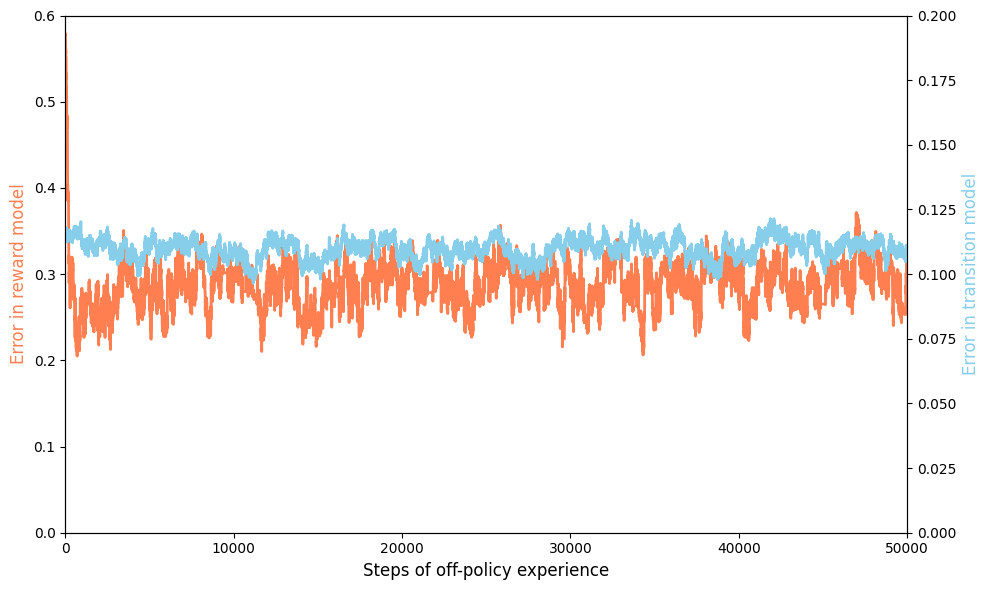

In [15]:
""" UP """

plot_model_results(
    average_error_rmses=np.mean(many_reward_model_rmses_up, axis=0),
    stddev_error_rmses=np.std(many_reward_model_rmses_up, axis=0),
    average_transition_error=np.mean(many_transition_model_errors_up, axis=0),
    stddev_transition_error=np.std(many_transition_model_errors_up, axis=0),
    number_of_steps=number_of_steps
)

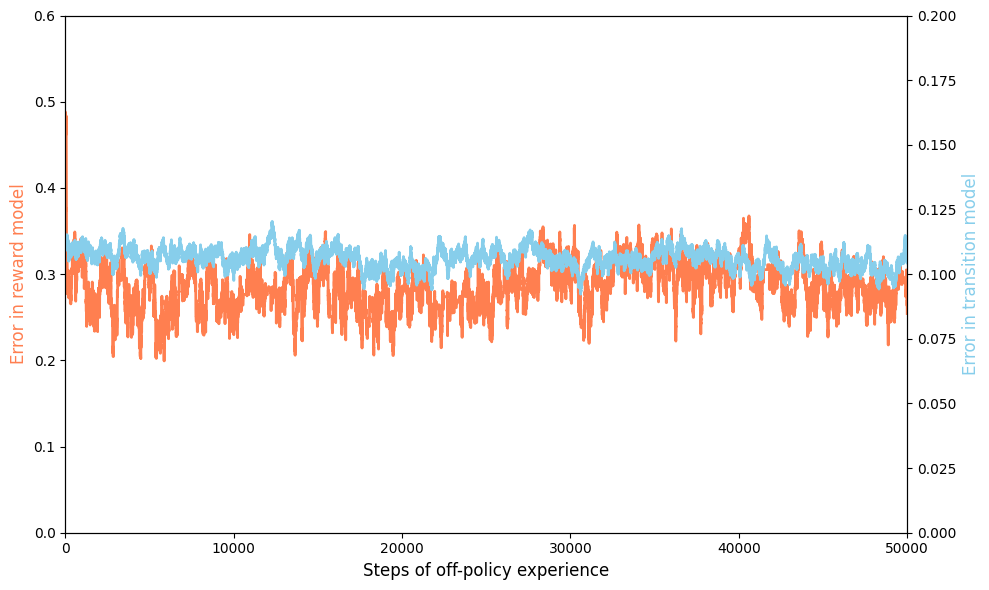

In [16]:
""" DOWN """

plot_model_results(
    average_error_rmses=np.mean(many_reward_model_rmses_down, axis=0),
    stddev_error_rmses=np.std(many_reward_model_rmses_down, axis=0),
    average_transition_error=np.mean(many_transition_model_errors_down, axis=0),
    stddev_transition_error=np.std(many_transition_model_errors_down, axis=0),
    number_of_steps=number_of_steps
)


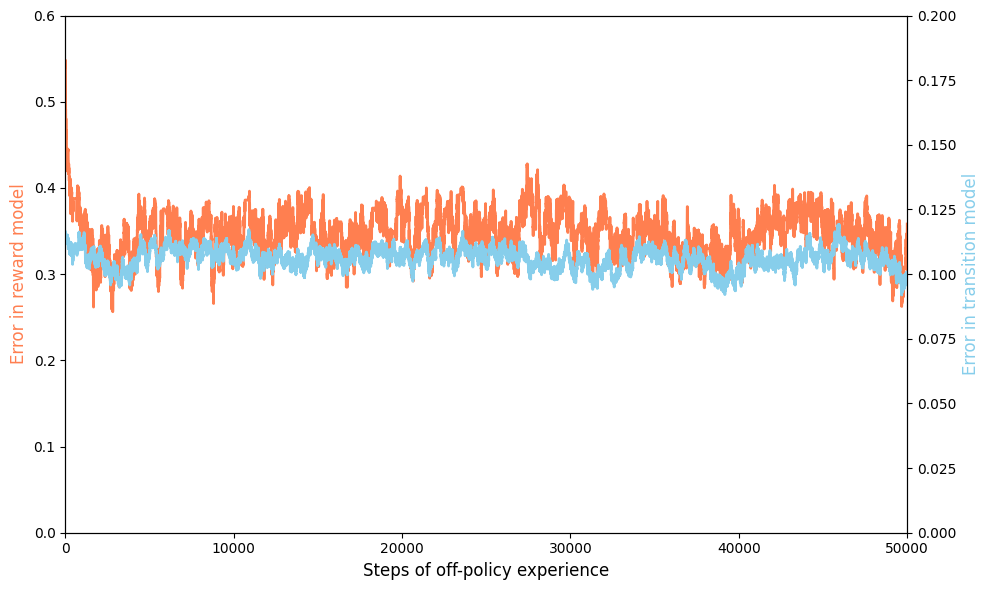

In [17]:
""" LEFT """

plot_model_results(
    average_error_rmses=np.mean(many_reward_model_rmses_left, axis=0),
    stddev_error_rmses=np.std(many_reward_model_rmses_left, axis=0),
    average_transition_error=np.mean(many_transition_model_errors_left, axis=0),
    stddev_transition_error=np.std(many_transition_model_errors_left, axis=0),
    number_of_steps=number_of_steps
)


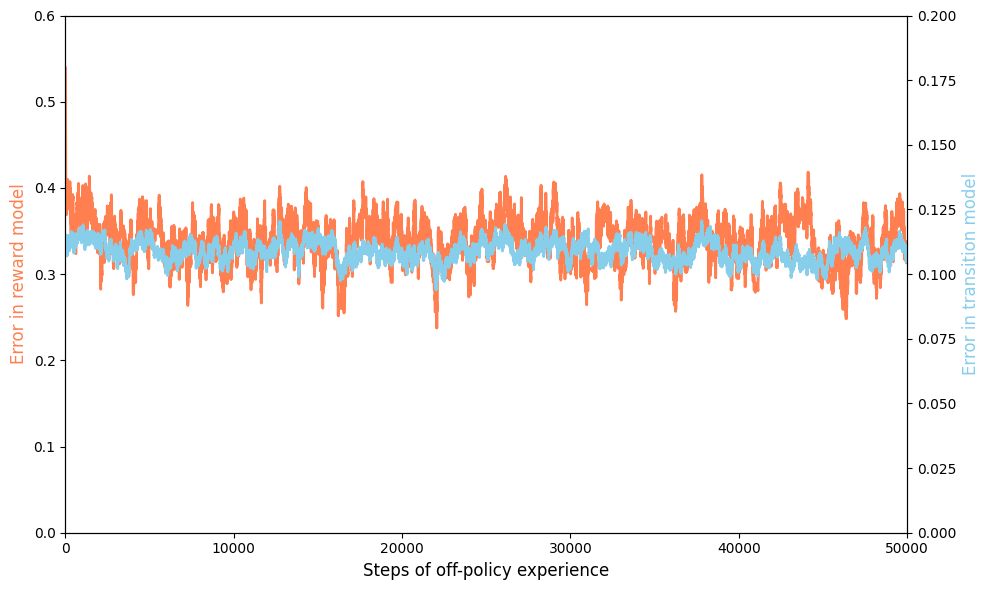

In [18]:
""" RIGHT """

plot_model_results(
    average_error_rmses=np.mean(many_reward_model_rmses_right, axis=0),
    stddev_error_rmses=np.std(many_reward_model_rmses_right, axis=0),
    average_transition_error=np.mean(many_transition_model_errors_right, axis=0),
    stddev_transition_error=np.std(many_transition_model_errors_right, axis=0),
    number_of_steps=number_of_steps
)
